# Fine-tuning InceptionV3 for food nutrition classifier

In [33]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import os.path
import numpy as np

### Database parameters

In [34]:
# Set metadata database paths
database_path = '../recipes/data.sqlite'

# Set image database paths
image_data_database_path = '../recipes/image_data_299.sqlite'

# Index cache
condition_indeces = None

#Set the id of classification stored in the database which will be used to train model.
classification_id = 5

### Training parameters

In [35]:
# Limit number of images used for training and testing.
train_max = 1000000
val_max = 1000000

# Image dimensions (Inception input size)
img_width, img_height = 299, 299

# Set batch size to biggest that fits in your memory.
batch_size = 64

# Number of epochs to train top inception network blocks.
top_epochs = 50

# Number of epochs to fine tune the network.
fit_epochs = 50

### Name the run

In [36]:
# Name the current parameters set. This name will be used as a Tensorboard log directory subfolder.
# having separate subfolder for each run will allow you to conviniently view performance changes beween runs.

run_name = "cid%d_tm%d_vm%d_bs%d_te%d_te%d" % (classification_id, 
                                               train_max, val_max, 
                                               batch_size, top_epochs, 
                                               fit_epochs)

print ("Run name: %s" % run_name)

Run name: cid5_tm1000000_vm1000000_bs64_te50_te50


### Initializing 

In [37]:
# Import custom SQLite data reader
from sqlite_data_loader import SQLiteDataLoader

sdl = SQLiteDataLoader(database_path, image_data_database_path)

# Load the number of nutrition classes
class_count = len(sdl.get_condition_indeces(classification_id))

print ("Number of nutrition classes: %d" % class_count)

Number of nutrition classes: 25


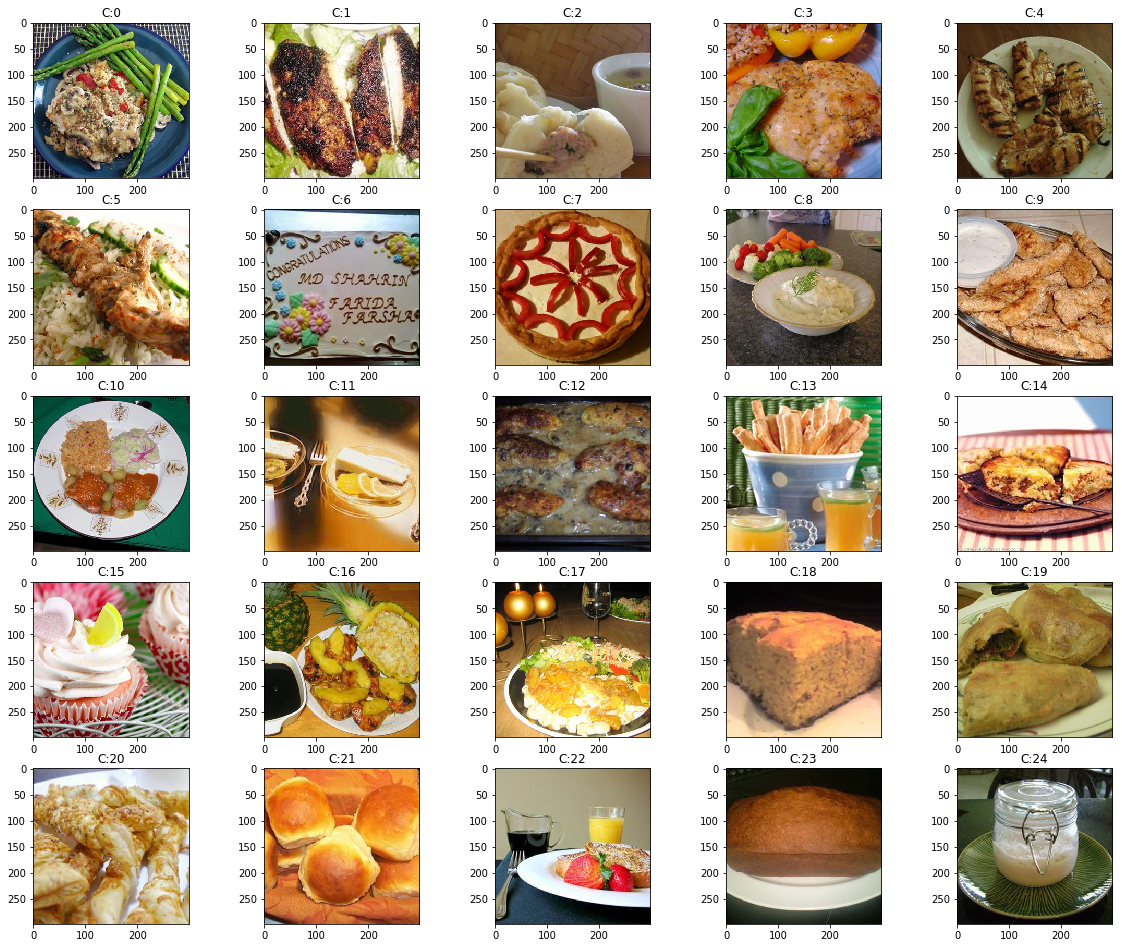

In [38]:
"""
Show an image for each nutrition class. 
"""

from image_ex import load_img_bytes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
columns = 5

for ci in range(class_count):
    image_id = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, 1)[0]
    image_data = sdl.get_image_data_by_id(image_id)
    pil_img = load_img_bytes(image_data, target_size=(img_width, img_height))
    
    sp = fig.add_subplot(class_count / columns + 1, columns, ci + 1)
    sp.set_title('C:%d'%ci)
    plt.imshow(pil_img)
    

In [39]:
# Get the number of train and validation samples
nb_train_samples = 0
nb_validation_samples = 0
for ci in sdl.get_condition_indeces(classification_id):
    nb_train_samples += sdl.get_image_count_by_condition_index(ci, classification_id, 0.7, train_max)
    nb_validation_samples += sdl.get_image_count_by_condition_index(ci, classification_id, 0.3, val_max)

print ("Train samples: %d" % nb_train_samples)
print ("Validation samples: %d" % nb_validation_samples)

Class 0 has 2063 images.
Class 1 has 527 images.
Class 2 has 8412 images.
Class 3 has 6046 images.
Class 4 has 8237 images.
Class 5 has 9768 images.
Class 6 has 1866 images.
Class 7 has 3942 images.
Class 8 has 1327 images.
Class 9 has 4952 images.
Class 10 has 1151 images.
Class 11 has 23630 images.
Class 12 has 13057 images.
Class 13 has 7091 images.
Class 14 has 13113 images.
Class 15 has 2894 images.
Class 16 has 14319 images.
Class 17 has 3286 images.
Class 18 has 34386 images.
Class 19 has 33915 images.
Class 20 has 14135 images.
Class 21 has 58266 images.
Class 22 has 8999 images.
Class 23 has 91888 images.
Class 24 has 36551 images.
Train samples: 282663
Validation samples: 121134


Visualize recipe classification

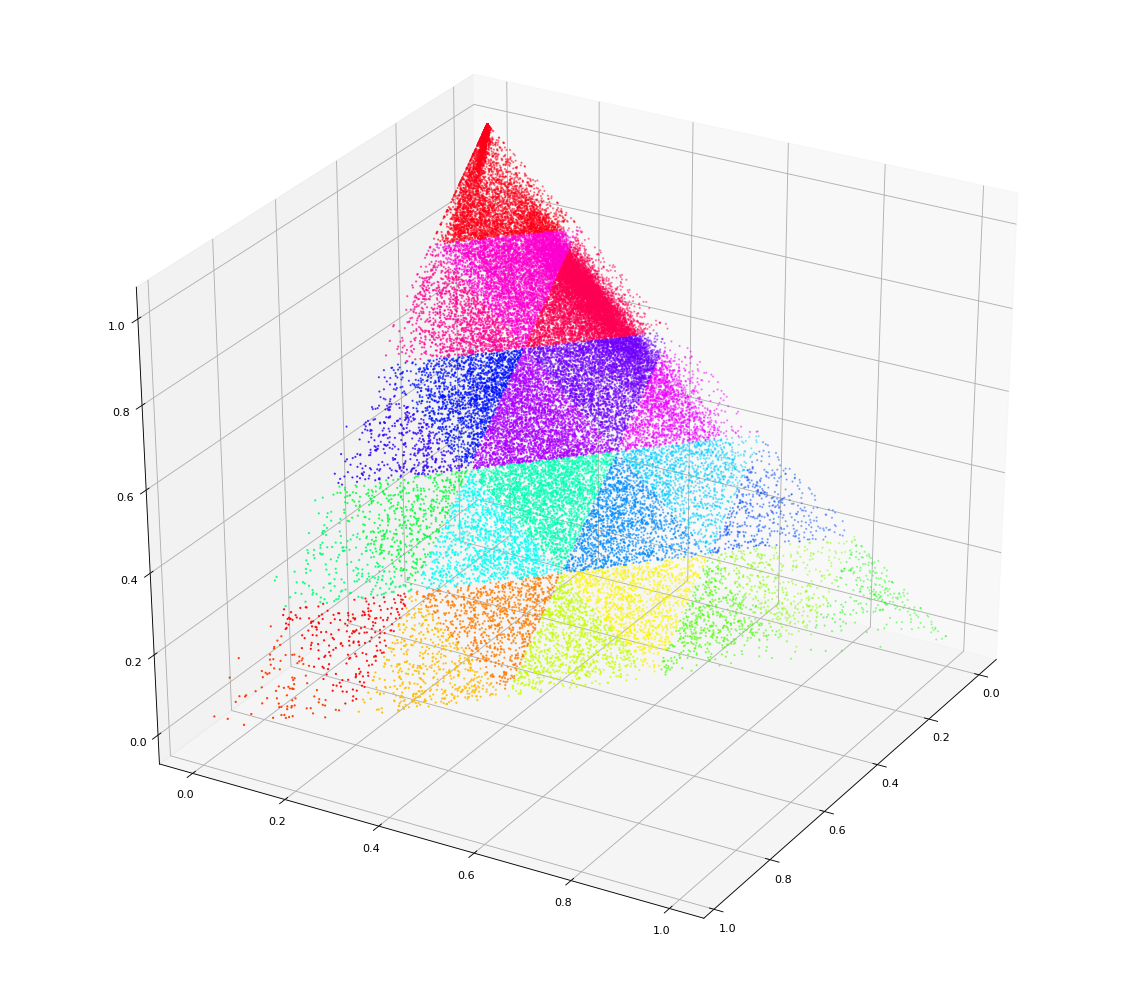

In [40]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

rates = np.array(sdl.get_nutrition_values(classification_id))

# Data for three-dimensional scattered points
xdata = rates[:,0]
ydata = rates[:,1]
zdata = rates[:,2]

cdata = rates[:,3]
cdata /= 25

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection='3d')
ax.view_init(30, 30)
ax.scatter3D(xdata, ydata, zdata, c=cdata, cmap='hsv', s=1);

## Building the model

In [41]:
# Set checkpoint save files
top_layers_checkpoint_path = 'cp.top.best.3.hdf5'
fine_tuned_checkpoint_path = 'cp.fine_tuned.best.3.hdf5'
new_extended_inception_weights = 'final_weights.3.hdf5'

In [42]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer    # ADDED BY ME
x = Dense(1024, activation='relu')(x)  # ADDED BY ME
# let's add a dropout regularization   # ADDED BY ME
x = Dropout(0.4)(x)                    # ADDED BY ME
# let's add a second fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 125 classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], )

/home/aleksas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


### Setup data generators

In [ ]:
# Import custom image data generator capable of taking lamda function to load data from SQLite 
from image_ex import ImageDataGeneratorEx

# prepare data augmentation configuration
train_datagen = ImageDataGeneratorEx(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGeneratorEx(rescale=1. / 255)

train_generator = train_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, 0.7, train_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, 0, sdl.get_image_count_by_condition_index(ci, classification_id, 0.7, train_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, 0.3, val_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, sdl.get_image_count_by_condition_index(ci, classification_id, 0.7, train_max), sdl.get_image_count_by_condition_index(ci, classification_id, 0.3, val_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 282663 images belonging to 25 classes.
Found 121134 images belonging to 25 classes.


In [38]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Save the TensorBoard logs.
tb = TensorBoard(log_dir=('./logs/%s'%run_name), histogram_freq=1, write_graph=True, write_images=True)

In [39]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=top_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tb])

INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; u

INFO:tensorflow:Summary name batch_normalization_6/beta:0 is illegal; using batch_normalization_6/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_6/beta:0 is illegal; using batch_normalization_6/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_6/moving_mean:0 is illegal; using batch_normalization_6/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_6/moving_mean:0 is illegal; using batch_normalization_6/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_6/moving_variance:0 is illegal; using batch_normalization_6/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_6/moving_variance:0 is illegal; using batch_normalization_6/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/beta:0 is illegal; using batch_normalization_8/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/beta:0 is illegal; using batch_normalization_8/beta_0 instead.
INFO:tensorflow:

INFO:tensorflow:Summary name batch_normalization_26/moving_variance:0 is illegal; using batch_normalization_26/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_28/kernel:0 is illegal; using conv2d_28/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_28/kernel:0 is illegal; using conv2d_28/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_28/beta:0 is illegal; using batch_normalization_28/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_28/beta:0 is illegal; using batch_normalization_28/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_28/moving_mean:0 is illegal; using batch_normalization_28/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_28/moving_mean:0 is illegal; using batch_normalization_28/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_28/moving_variance:0 is illegal; using batch_normalization_28/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normaliza

INFO:tensorflow:Summary name batch_normalization_33/beta:0 is illegal; using batch_normalization_33/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_33/moving_mean:0 is illegal; using batch_normalization_33/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_33/moving_mean:0 is illegal; using batch_normalization_33/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_33/moving_variance:0 is illegal; using batch_normalization_33/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_33/moving_variance:0 is illegal; using batch_normalization_33/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_38/beta:0 is illegal; using batch_normalization_38/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_38/beta:0 is illegal; using batch_normalization_38/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_38/moving_mean:0 is illegal; using batch_normalization_38/moving_me

INFO:tensorflow:Summary name batch_normalization_56/moving_variance:0 is illegal; using batch_normalization_56/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_56/moving_variance:0 is illegal; using batch_normalization_56/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_52/kernel:0 is illegal; using conv2d_52/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_52/kernel:0 is illegal; using conv2d_52/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_57/kernel:0 is illegal; using conv2d_57/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_57/kernel:0 is illegal; using conv2d_57/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_52/beta:0 is illegal; using batch_normalization_52/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_52/beta:0 is illegal; using batch_normalization_52/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_52/moving_mean:0 is illegal; using batch_normalization_52/moving_me

INFO:tensorflow:Summary name batch_normalization_69/moving_mean:0 is illegal; using batch_normalization_69/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_69/moving_variance:0 is illegal; using batch_normalization_69/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_69/moving_variance:0 is illegal; using batch_normalization_69/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_70/beta:0 is illegal; using batch_normalization_70/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_70/beta:0 is illegal; using batch_normalization_70/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_70/moving_mean:0 is illegal; using batch_normalization_70/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_70/moving_mean:0 is illegal; using batch_normalization_70/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_70/moving_variance:0 is illegal; using batch_normaliz

INFO:tensorflow:Summary name batch_normalization_78/beta:0 is illegal; using batch_normalization_78/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_78/beta:0 is illegal; using batch_normalization_78/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_78/moving_mean:0 is illegal; using batch_normalization_78/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_78/moving_mean:0 is illegal; using batch_normalization_78/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_78/moving_variance:0 is illegal; using batch_normalization_78/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_78/moving_variance:0 is illegal; using batch_normalization_78/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_82/beta:0 is illegal; using batch_normalization_82/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_82/beta:0 is illegal; using batch_normalization_82/beta_0 instead.


INFO:tensorflow:Summary name conv2d_87/kernel:0 is illegal; using conv2d_87/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_87/kernel:0 is illegal; using conv2d_87/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_91/kernel:0 is illegal; using conv2d_91/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_91/kernel:0 is illegal; using conv2d_91/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_87/beta:0 is illegal; using batch_normalization_87/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_87/beta:0 is illegal; using batch_normalization_87/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_87/moving_mean:0 is illegal; using batch_normalization_87/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_87/moving_mean:0 is illegal; using batch_normalization_87/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_87/moving_variance:0 is illegal; using batch_normalization_87/moving_variance_0 ins

INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.
INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.
INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
Epoch 1/50


KeyboardInterrupt: 

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [12]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [13]:
# Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Load saved wights
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")


In [14]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

In [15]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=fit_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

Epoch 1/50


KeyboardInterrupt: 